In [1]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd
import numpy as np

from tqdm import tqdm

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier

from ipywidgets import interactive

from collections import defaultdict

import hdbscan
import folium
import re


cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
        '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
        '#000075', '#808080']*10

In [2]:
df=pd.read_csv('taxi_data.csv')
df.head()

LON       LAT                          NAME
0  28.17858 -25.73882         11th Street Taxi Rank
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank
2  27.83239 -26.53722          Adams Road Taxi Rank
3  28.12514 -26.26666  Alberton City Mall Taxi Rank
4  28.10144 -26.10567      Alexandra Main Taxi Rank

In [3]:
df.duplicated(subset=["LON","LAT"]).values.any()

True

In [4]:
df.isna().values.any()

True

In [5]:
df.dropna(inplace=True)

In [6]:
df.shape

(837, 3)

In [7]:
df.drop_duplicates(subset=['LON', 'LAT'], keep='first', inplace=True)

In [8]:
df.shape

(823, 3)

In [9]:
x = np.array(df[['LON','LAT']],dtype='float64')

In [10]:
x

array([[ 28.17858, -25.73882],
       [ 28.1766 , -25.73795],
       [ 27.83239, -26.53722],
       ...,
       [ 27.83991, -26.24235],
       [ 27.86166, -26.23624],
       [ 28.39097, -26.30931]])

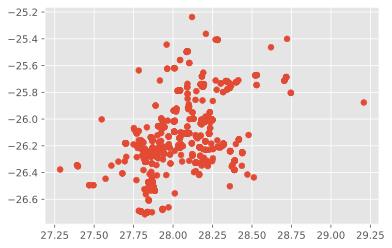

In [11]:
x1=df['LON']
y1=df['LAT']
plt.scatter(x1,y1)

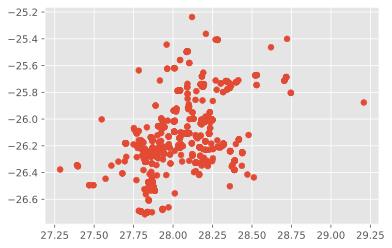

In [12]:
plt.scatter(x[:,0],x[:,1])

In [13]:
m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9,tiles='Stamen Toner')

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row.LAT, row.LON],
        radius=5,
        popup=re.sub(r'[^a-zA-Z ]+', '', row.NAME),
        color='#1787FE',
        fill=True,
        fill_colour='#1787FE'
    ).add_to(m)
    folium.Marker([row.LAT, row.LON], 
               popup = re.sub(r'[^a-zA-Z ]+', '', row.NAME)).add_to(m)

In [14]:
m

In [15]:
df.head()

LON       LAT                          NAME
0  28.17858 -25.73882         11th Street Taxi Rank
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank
2  27.83239 -26.53722          Adams Road Taxi Rank
3  28.12514 -26.26666  Alberton City Mall Taxi Rank
4  28.10144 -26.10567      Alexandra Main Taxi Rank

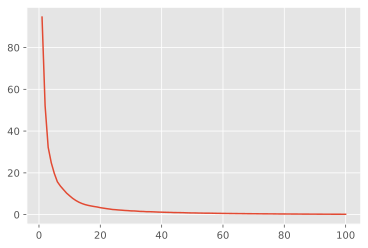

In [16]:
X = df.iloc[:,[0,1]].values
# finding number of clusters using the elbow method
wcss = []
for i in range(1, 101):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,101),wcss)
plt.show()

In [17]:
kmeans=KMeans(n_clusters=70,init='k-means++',max_iter=300,n_init=10,random_state=0)
y_kmeans=kmeans.fit_predict(X)

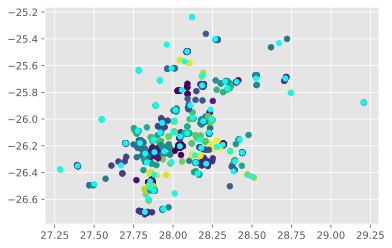

In [18]:
plt.scatter(X[:,0], X[:,1],c=y_kmeans)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=30, c='cyan')
plt.show()

In [19]:
df['CLUSTER_kmeans70'] = y_kmeans

In [20]:
df.head()

LON       LAT                          NAME  CLUSTER_kmeans70
0  28.17858 -25.73882         11th Street Taxi Rank                14
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank                14
2  27.83239 -26.53722          Adams Road Taxi Rank                60
3  28.12514 -26.26666  Alberton City Mall Taxi Rank                67
4  28.10144 -26.10567      Alexandra Main Taxi Rank                43

In [21]:
def create_map(df, cluster_column):
    m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9,tiles='Stamen Toner')
    for _, row in df.iterrows():
        if row[cluster_column] == -1:
            cluster_colour = '#000000'
        else:
            cluster_colour = cols[row[cluster_column]]
            
        folium.Marker(
            location=[row['LAT'], row['LON']],
            popup = row[cluster_column],
        ).add_to(m)
        folium.CircleMarker(
            location= [row['LAT'], row['LON']],
            radius=5,
            popup= row[cluster_column],
            color=cluster_colour,
            fill=True,
            fill_color=cluster_colour
        ).add_to(m)
        
    return m

m = create_map(df, 'CLUSTER_kmeans70')
#print(f'K={k}')
#print(f'Silhouette Score: {silhouette_score(X, class_predictions)}')
m.save('kmeans_70.html')

# clustering with DBSCAN


In [22]:
model = DBSCAN(eps=0.01, min_samples=5).fit(X)
class_predictions = model.labels_    # use labels_ instead of predict() method??
df['CLUSTERS_DBSCAN'] = class_predictions   #update the column with new clustered values
m = create_map(df, 'CLUSTERS_DBSCAN')  #calling the method "create_map" for making map with new clusters

In [23]:
m

# DBSCAN  is not performing well and declaring less dense points as outliers...
# hence we'll use HDBSCAN here

In [24]:
model = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2, cluster_selection_epsilon=0.01)
class_predictions = model.fit_predict(X)
df['CLUSTER_HDBSCAN'] = class_predictions  # updating new clusters
m = create_map(df,'CLUSTER_HDBSCAN')
m

# It's working better but we have to take care of outliers also and classify them each a new cluster using KNN algo

In [25]:
classifier = KNeighborsClassifier(n_neighbors=1)   # bcz each of them are gonna be classified so n_neighbors = 1
df_train = df[df.CLUSTER_HDBSCAN!=-1]                 # train the model excluding the ouliers
df_predict = df[df.CLUSTER_HDBSCAN==-1]              # test on outliers
X_train = np.array(df_train[['LON', 'LAT']], dtype='float64')
y_train = np.array(df_train['CLUSTER_HDBSCAN'])

X_predict = np.array(df_predict[['LON', 'LAT']], dtype='float64')
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [26]:
predictions = classifier.predict(X_predict)
df['CLUSTER_hybrid'] = df['CLUSTER_HDBSCAN']
df.loc[df.CLUSTER_HDBSCAN==-1, 'CLUSTER_hybrid'] = predictions
m = create_map(df, 'CLUSTER_hybrid')
m